# AUVs: Accessing IOOS and OOI glider data from the IOOS Glider DAC via ERDDAP and erddapy
This notebook is a copy of the OceanHackWeek'18 notebook [ioos_data_access/03-gliderdac_erddapy.ipynb](https://github.com/oceanhackweek/ohw2018_tutorials/blob/master/day2/ioos_data_access/03-gliderdac_erddapy.ipynb), with small updates.

- [Emilio Mayorga](https://github.com/emiliom), University of Washington & [NANOOS](http://www.nanoos.org/)

[OceanHackWeek 2019](https://oceanhackweek.github.io/)

[IOOS Glider Data Assembly Center (DAC):](https://gliders.ioos.us/) "The mission of the Glider DAC is to provide glider operators with a simple process for submitting glider data sets to a centralized location, enabling the data to be visualized, analyzed, widely distributed via existing web services and the Global Telecommunications System (GTS) and archived at the National Centers for Environmental Information (NCEI)." *A lot of OOI glider data are also available on the Glider DAC (at least through March 2018).*

Glider DAC data are available for access online via user applications such as the [Glider Map](https://gliders.ioos.us/map/) as well as via other applications and data services for machine-to-machine access. **ERDDAP** (see [here](https://coastwatch.pfeg.noaa.gov/erddapinfo/) and [here](https://coastwatch.pfeg.noaa.gov/erddap/index.html)) is one of those applicattions. "ERDDAP is a data server that gives you a simple, consistent way to download data in the format and the spatial and temporal coverage that you want. ERDDAP is a web application with an interface for people to use. It is also a RESTful web service that allows data access directly from any computer program (e.g. Matlab, R, or webpages)."

ERDDAP has RESTful API that is very convenient for creating web apps, data portals, etc. However, writing those URLs manually can be tedious and error prone. This notebook walks through an easy to set up ERDDAP RESTful URL by using the python client, `erddapy`, https://pyoceans.github.io/erddapy/

A typical ERDDAP RESTful URL looks like:

[https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.mat?depth,latitude,longitude,salinity,temperature,time&time>=2016-07-10T00:00:00Z&time<=2017-02-10T00:00:00Z &latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0](https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.mat?depth,latitude,longitude,salinity,temperature,time&time>=2016-07-10T00:00:00Z&time<=2017-02-10T00:00:00Z&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0)

Let's break it down to smaller parts:

- **server**: https://data.ioos.us/gliders/erddap/
- **protocol**: tabledap
- **dataset_id**: whoi_406-20160902T1700
- **response**: .mat
- **variables**: depth,latitude,longitude,temperature,time
- **constraints**:
    - time>=2016-07-10T00:00:00Z
    - time<=2017-02-10T00:00:00Z
    - latitude>=38.0
    - latitude<=41.0
    - longitude>=-72.0
    - longitude<=-69.0

This Jupyter notebook is based on a notebook from the IOOS gallery, at http://ioos.github.io/notebooks_demos/notebooks/2018-03-01-erddapy/. A newer version of that notebook is available at https://pyoceans.github.io/erddapy/quick_intro.html, and an even newer version at [this gist](http://nbviewer.jupyter.org/gist/ocefpaf/2e45fe0bdd0320496aa3b7f98f07a4d9) from https://github.com/ocefpaf.

## Preamble

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import folium

import pandas as pd
import geopandas as gpd
import shapely.geometry as shpgeom

from erddapy import ERDDAP

In [2]:
# Glider DAC server endpoint
server = 'https://data.ioos.us/gliders/erddap'
protocol = 'tabledap'

Specify the **OOI Endurance Array geographical bounding box**, then read into a `Shapely` geometry (polygon) and a `GeoPandas` GeoSeries for convenience and reuse.

In [3]:
min_lon, max_lon = -127, -123.75
min_lat, max_lat = 43, 48

endurance_bbox_shp = shpgeom.box(min_lon, min_lat, max_lon, max_lat)
endurance_bbox_gs = gpd.GeoSeries(endurance_bbox_shp)

Feeding these variables in the `erddapy.ERDDAP` class we will create the URL builder object.

## 1. Search ERDDAP "catalog"

In [4]:
e = ERDDAP(server=server, protocol=protocol)

A search for everything looks like this. The only effective filtering parameters being passed are `protocol=tabledap` and `response=csv`.

In [5]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='all'))
len(df)

547

Now we'll refine our search by adding temporal, bounding box and variable constraints.

In [6]:
min_time = '2015-01-01T00:00:00Z'
max_time = '2016-12-31T00:00:00Z'

kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': min_lon,
    'max_lon': max_lon,
    'min_lat': min_lat,
    'max_lat': max_lat,
    'min_time': min_time,
    'max_time': max_time,
}

In [7]:
search_url = e.get_search_url(response='csv', **kw)
search = pd.read_csv(search_url)

gliders = search['Dataset ID'].values

msg = 'Found {} Glider Datasets:\n\n{}'.format
print(msg(len(gliders), '\n'.join(gliders)))

Found 28 Glider Datasets:

ce_247-20160510T0242
ce_247-20160928T2157
ce_311-20160122T2045
ce_311-20161011T2101
ce_312-20160122T2140
ce_312-20160920T1743
ce_319-20151008T2255
ce_319-20160616T1912
ce_320-20160616T2004
ce_326-20150410T1942
ce_326-20151015T1908
ce_326-20160217T1655
ce_327-20150603T0000
ce_327-20151015T1701
ce_327-20160923T0147
ce_327-20161215T2058
ce_382-20150121T2202
ce_382-20160928T2102
ce_383-20150121T2028
ce_383-20150813T2109
ce_384-20150411T1807
ce_384-20160507T1655
ce_386-20150404T1729
ce_386-20151015T2247
ce_386-20160922T2355
ce_386-20161215T1736
SG187-20140625T1330
UW157-20141116T2118


In [8]:
# A simple value_counts() is less readable. So, display as DataFrame
pd.DataFrame(search.Institution.value_counts()).head()

,Institution
Ocean Observatories Initiative,26
"Applied Physics Lab\nUniversity of Washington\nSeattle, WA",1
Oregon State University,1


Results: 26 OOI datasets and 2 (1 UW-led + 1 OSU-led) NANOOS datasets.

In [9]:
search.head()

,griddap,Subset,tabledap,Make A Graph,wms,files,Title,Summary,FGDC,ISO 19115,Info,Background Info,RSS,Email,Institution,Dataset ID
0,NaN,https://gliders.ioos.us/erddap/tabledap/ce_247...,https://gliders.ioos.us/erddap/tabledap/ce_247...,https://gliders.ioos.us/erddap/tabledap/ce_247...,NaN,NaN,ce_247-20160510T0242,The Endurance Array is a multi-scaled array ut...,https://gliders.ioos.us/erddap/metadata/fgdc/x...,https://gliders.ioos.us/erddap/metadata/iso191...,https://gliders.ioos.us/erddap/info/ce_247-201...,http://data.ioos.us/gliders/erddap/,https://gliders.ioos.us/erddap/rss/ce_247-2016...,https://gliders.ioos.us/erddap/subscriptions/a...,Ocean Observatories Initiative,ce_247-20160510T0242
1,NaN,https://gliders.ioos.us/erddap/tabledap/ce_247...,https://gliders.ioos.us/erddap/tabledap/ce_247...,https://gliders.ioos.us/erddap/tabledap/ce_247...,NaN,NaN,ce_247-20160928T2157,The Endurance Array is a multi-scaled array ut...,https://gliders.ioos.us/erddap/metadata/fgdc/x...,https://gliders.ioos.us/erddap/metadata/iso191...,https://gliders.ioos.us/erddap/info/ce_247-201...,http://data.ioos.us/gliders/erddap/,https://gliders.ioos.us/erddap/rss/ce_247-2016...,https://gliders.ioos.us/erddap/subscriptions/a...,Ocean Observatories Initiative,ce_247-20160928T2157
2,NaN,https://gliders.ioos.us/erddap/tabledap/ce_311...,https://gliders.ioos.us/erddap/tabledap/ce_311...,https://gliders.ioos.us/erddap/tabledap/ce_311...,NaN,NaN,ce_311-20160122T2045,The Endurance Array is a multi-scaled array ut...,https://gliders.ioos.us/erddap/metadata/fgdc/x...,https://gliders.ioos.us/erddap/metadata/iso191...,https://gliders.ioos.us/erddap/info/ce_311-201...,http://data.ioos.us/gliders/erddap/,https://gliders.ioos.us/erddap/rss/ce_311-2016...,https://gliders.ioos.us/erddap/subscriptions/a...,Ocean Observatories Initiative,ce_311-20160122T2045
3,NaN,https://gliders.ioos.us/erddap/tabledap/ce_311...,https://gliders.ioos.us/erddap/tabledap/ce_311...,https://gliders.ioos.us/erddap/tabledap/ce_311...,NaN,NaN,ce_311-20161011T2101,The Endurance Array is a multi-scaled array ut...,https://gliders.ioos.us/erddap/metadata/fgdc/x...,https://gliders.ioos.us/erddap/metadata/iso191...,https://gliders.ioos.us/erddap/info/ce_311-201...,http://data.ioos.us/gliders/erddap/,https://gliders.ioos.us/erddap/rss/ce_311-2016...,https://gliders.ioos.us/erddap/subscriptions/a...,Ocean Observatories Initiative,ce_311-20161011T2101
4,NaN,https://gliders.ioos.us/erddap/tabledap/ce_312...,https://gliders.ioos.us/erddap/tabledap/ce_312...,https://gliders.ioos.us/erddap/tabledap/ce_312...,NaN,NaN,ce_312-20160122T2140,The Endurance Array is a multi-scaled array ut...,https://gliders.ioos.us/erddap/metadata/fgdc/x...,https://gliders.ioos.us/erddap/metadata/iso191...,https://gliders.ioos.us/erddap/info/ce_312-201...,http://data.ioos.us/gliders/erddap/,https://gliders.ioos.us/erddap/rss/ce_312-2016...,https://gliders.ioos.us/erddap/subscriptions/a...,Ocean Observatories Initiative,ce_312-20160122T2140


## 2. Investigate one glider dataset, picked manually
Let's inspect a specific `dataset_id`.

In [10]:
dataset_id = 'ce_327-20160923T0147'

### Investigate metadata for one dataset

In [11]:
info_url = e.get_info_url(dataset_id=dataset_id, response='csv')
info = pd.read_csv(info_url)

In [12]:
# Lots of metadata available
len(info)

569

In [13]:
info.head(20)

,Row Type,Variable Name,Attribute Name,Data Type,Value
0,attribute,NC_GLOBAL,_NCProperties,String,version=1|netcdflibversion=4.4.1|hdf5libversio...
1,attribute,NC_GLOBAL,acknowledgment,String,Funding provided by the National Science Found...
2,attribute,NC_GLOBAL,cdm_data_type,String,TrajectoryProfile
3,attribute,NC_GLOBAL,cdm_profile_variables,String,"time_uv,lat_uv,lon_uv,u,v,profile_id,time,lati..."
4,attribute,NC_GLOBAL,cdm_trajectory_variables,String,"trajectory,wmo_id"
5,attribute,NC_GLOBAL,contributor_name,String,"Ed Dever,Jon Fram,Stuart Pearce,John Kerfoot"
6,attribute,NC_GLOBAL,contributor_role,String,"Endurance Array Program Manager,Endurance Arra..."
7,attribute,NC_GLOBAL,Conventions,String,"Unidata Dataset Discovery v1.0, COARDS, CF-1.6"
8,attribute,NC_GLOBAL,creator_email,String,kerfoot@marine.rutgers.edu
9,attribute,NC_GLOBAL,creator_name,String,John Kerfoot


In [14]:
info.groupby(['Variable Name', 'Row Type']).size()

Variable Name    Row Type 
NC_GLOBAL        attribute    60
conductivity     attribute    17
                 variable      1
conductivity_qc  attribute    10
                 variable      1
density          attribute    17
                 variable      1
density_qc       attribute    10
                 variable      1
depth            attribute    22
                 variable      1
depth_qc         attribute    10
                 variable      1
instrument_ctd   attribute     8
                 variable      1
lat_uv           attribute    14
                 variable      1
lat_uv_qc        attribute     9
                 variable      1
latitude         attribute    17
                 variable      1
latitude_qc      attribute     9
                 variable      1
lon_uv           attribute    14
                 variable      1
lon_uv_qc        attribute     9
                 variable      1
longitude        attribute    17
                 variable      1
longitude_qc    

With the info URL we can filter the data using attributes.

In [15]:
cdm_profile_variables = info.loc[
    info['Attribute Name'] == 'cdm_profile_variables', 'Variable Name'
]

cdm_profile_variables

3    NC_GLOBAL
Name: Variable Name, dtype: object

In fact, that is such a common operation that `erddapy` brings its own method for filtering data by attributes directly from server information. Below we request the variable names that have a `cdm_profile_variables`, a `standard_name` of `sea_water_temperature`, and an axis respectively.

In [16]:
e.get_var_by_attr(
    dataset_id=dataset_id,
    cdm_profile_variables=lambda v: v is not None,
)

['NC_GLOBAL']

In [17]:
e.get_var_by_attr(
    dataset_id=dataset_id,
    standard_name='sea_water_temperature',
)

['temperature']

In [18]:
e.get_var_by_attr(
    dataset_id=dataset_id,
    axis=lambda v: v in ['X', 'Y', 'Z', 'T'],
)

['precise_time',
 'latitude',
 'pressure',
 'depth',
 'precise_lon',
 'precise_lat',
 'time',
 'longitude']

### Read and transform the data

In [19]:
variables = [
 'depth',
 'latitude',
 'longitude',
 'salinity',
 'temperature',
 'time',
]

# No spatial or temporal constraints specified, because we're pulling in the entire dataset

Reuse `e`

In [20]:
e.dataset_id = dataset_id
e.variables = variables

To get data back as a Matlab `mat` file, use a request like this:

In [21]:
e.get_download_url(response='mat')

'https://data.ioos.us/gliders/erddap/tabledap/ce_327-20160923T0147.mat?depth,latitude,longitude,salinity,temperature,time'

Additionally, the object has `.get_info_url()` and `.get_search_url()` that can be used to obtain the info and search URLs respectively

`erddapy` also provides some simple methods to download the data transformed into common Python data structures, like `pandas.DataFrame` and `xarray.Dataset`. Below, commented out, is a sample request to get back data as a Pandas DataFrame.

In [22]:
# df = e.to_pandas(
#     index_col='time',
#     parse_dates=True,
#     skiprows=(1,)  # drop the units row (second header row)
# ).dropna()

# df.head()

Reading into `xarray` has the advantage of bringing much richer metadata when available (at the level of both the dataset and variables) which `pandas` data frames don't readily support. This may come at the cost of the somewhat more complex data structures if you're not used to netCDF.

In [23]:
ds = e.to_xarray(decode_times=True)

The metadata you see here is based on the NetCDF / CF / ACDD "ecosystem" of metadata conventions.

In [24]:
ds

<xarray.Dataset>
Dimensions:      (row: 18694)
Dimensions without coordinates: row
Data variables:
    depth        (row) float32 ...
    latitude     (row) float64 ...
    longitude    (row) float64 ...
    salinity     (row) float32 ...
    temperature  (row) float32 ...
    time         (row) datetime64[ns] ...
Attributes:
    acknowledgment:                Funding provided by the National Science F...
    cdm_data_type:                 TrajectoryProfile
    cdm_profile_variables:         time_uv,lat_uv,lon_uv,u,v,profile_id,time,...
    cdm_trajectory_variables:      trajectory,wmo_id
    contributor_name:              Ed Dever,Jon Fram,Stuart Pearce,John Kerfoot
    contributor_role:              Endurance Array Program Manager,Endurance ...
    Conventions:                   Unidata Dataset Discovery v1.0, COARDS, CF...
    creator_email:                 kerfoot@marine.rutgers.edu
    creator_name:                  John Kerfoot
    creator_url:                   http://www.whoi.e

In [25]:
ds['temperature']

<xarray.DataArray 'temperature' (row: 18694)>
array([16.1662, 15.8635, 12.2676, ..., 12.1134, 11.623 , 10.498 ],
      dtype=float32)
Dimensions without coordinates: row
Attributes:
    _ChunkSizes:          1
    actual_range:         [ 0.     17.3803]
    ancillary_variables:  temperature_qc
    colorBarMaximum:      32.0
    colorBarMinimum:      0.0
    coordinates:          time lat lon depth
    instrument:           instrument_ctd
    ioos_category:        Temperature
    long_name:            Sea Water Temperature
    observation_type:     measured
    platform:             platform
    source_variable:      sci_water_temp
    standard_name:        sea_water_temperature
    units:                degree_Celsius
    valid_max:            40.0
    valid_min:            -5.0

Now let's create a simple scatter plot using the data from `xarray` dataset (ds).

In [26]:
temperature_df = ds.to_dataframe()
temperature_df.set_index('time', inplace=True)
temperature_df.head()

,depth,latitude,longitude,salinity,temperature
time,,,,,
2016-09-23 02:53:59.003750144,6.029532,46.844764,-124.970629,32.036079,16.166201
2016-09-23 02:53:59.003750144,17.721159,46.844764,-124.970629,32.065552,15.863500
2016-09-23 02:53:59.003750144,29.084904,46.844764,-124.970629,32.625832,12.267600
2016-09-23 02:53:59.003750144,39.337505,46.844764,-124.970629,32.647892,10.888100
2016-09-23 02:53:59.003750144,49.123608,46.844764,-124.970629,32.663166,10.178000


In [27]:
ds

<xarray.Dataset>
Dimensions:      (row: 18694)
Dimensions without coordinates: row
Data variables:
    depth        (row) float32 6.029532 17.721159 29.084904 ... nan nan nan
    latitude     (row) float64 46.84 46.84 46.84 46.84 46.84 ... nan nan nan nan
    longitude    (row) float64 -125.0 -125.0 -125.0 -125.0 ... nan nan nan nan
    salinity     (row) float32 32.03608 32.06555 ... 32.656075 32.954113
    temperature  (row) float32 16.1662 15.8635 12.2676 ... 12.1134 11.623 10.498
    time         (row) datetime64[ns] 2016-09-23T02:53:59.003750144 ... 2016-10-23T07:21:43.301120
Attributes:
    acknowledgment:                Funding provided by the National Science F...
    cdm_data_type:                 TrajectoryProfile
    cdm_profile_variables:         time_uv,lat_uv,lon_uv,u,v,profile_id,time,...
    cdm_trajectory_variables:      trajectory,wmo_id
    contributor_name:              Ed Dever,Jon Fram,Stuart Pearce,John Kerfoot
    contributor_role:              Endurance Array P

### Create a section plot of the temperature data (depth vs time)
Plot using a matplotlib scatter plot with colored dots. Label axes and colorbar using variable attributes extracted directly from the `xarray` dataset.

/home/mayorga/miniconda/envs/OHW19/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


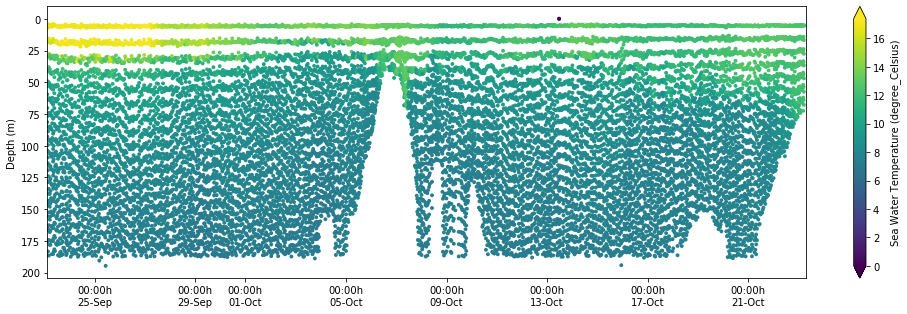

In [28]:
import matplotlib.dates as mdates


fig, ax = plt.subplots(figsize=(17, 5))
kw = dict(s=15, c=temperature_df['temperature'], marker='o', edgecolor='none')
cs = ax.scatter(temperature_df.index, temperature_df['depth'], **kw)

ax.invert_yaxis()
ax.set_xlim(temperature_df.index[0], temperature_df.index[-1])

xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('{} ({})'.format(ds.temperature.attrs['long_name'], ds.temperature.attrs['units']))
ax.set_ylabel('Depth ({})'.format(ds['depth'].attrs['units']));

One can build the proper variables programmatically, feed them in erddapy, and then build a service like [this notebook](https://mybinder.org/v2/gh/ioos/BioData-Training-Workshop/master?filepath=notebooks/ERDDAP_timeseries_explorer-IOOS.ipynb). However, erddapy is also designed for interactive work. One can explore interactively the ERDDAP server from Python.

PS: Note that in this example we did not feed any variables other than the server URL

### Plot the glider track on a simple map, for reference
We'll first convert the DataFrame to a `GeoPandas` GeoDataFrame, to take advantage of GeoPandas' convenience with spatial data.

In [29]:
temperature_gdf = gpd.GeoDataFrame(temperature_df,
                                   geometry=temperature_df[['longitude', 'latitude']].apply(
                                       shpgeom.Point, axis=1))

In [30]:
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

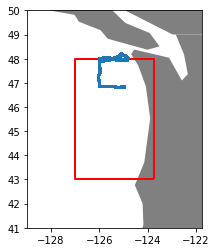

In [31]:
ax = endurance_bbox_gs.plot(ax=world_gdf.plot(facecolor='gray', figsize=(4, 4)), 
                            facecolor='none', edgecolor='red', linewidth=2)
temperature_gdf.plot(ax=ax, markersize=3)

bounds = endurance_bbox_gs.geometry.bounds
ax.set_xlim([bounds.minx[0]-2, bounds.maxx[0]+2])
ax.set_ylim([bounds.miny[0]-2, bounds.maxy[0]+2]);

## 3. Query and plot all track points, from all datasets returned by the initial query, using interative Folium map 

### Query, download and process the glider track data, by obtaining one glider dataset at a time

In [32]:
e = ERDDAP(server=server, protocol=protocol)

In [33]:
variables = [
 'latitude',
 'longitude',
]

constraints = {
    'time>=': min_time,
    'time<=': max_time,
}

In [34]:
from requests.exceptions import HTTPError

tracks_df_lst = []
for glider in gliders:
    try:
        download_url = e.get_download_url(
            protocol='tabledap',
            response='csv',
            dataset_id=glider,
            variables=variables,
            constraints=constraints
        )
        download_url += '&distinct()'
    except HTTPError:
        continue
    
    track_df = pd.read_csv(download_url, skiprows=[1])
    track_df['glider'] = glider
    tracks_df_lst.append(track_df)

Create a Geopandas GeoDataFrame out of the data that was downloaded. A GeoDataFrame can be leveraged for more convenient spatial exploration.

In [35]:
tracks_df = pd.concat(tracks_df_lst)
tracks_df.dropna(axis='index', how='any', inplace=True)
tracks_gdf = gpd.GeoDataFrame(tracks_df,
                              geometry=tracks_df[['longitude', 'latitude']].apply(shpgeom.Point, axis=1))

In [36]:
tracks_gdf.head()

,latitude,longitude,glider,geometry
0,44.295774,-124.934671,ce_247-20160510T0242,POINT (-124.9346713548978 44.29577371160638)
1,44.298201,-124.939611,ce_247-20160510T0242,POINT (-124.9396114828845 44.29820079195443)
2,44.298655,-124.933415,ce_247-20160510T0242,POINT (-124.9334150703943 44.29865516378541)
3,44.300082,-124.933344,ce_247-20160510T0242,POINT (-124.9333438004509 44.30008218313972)
4,44.302146,-124.935426,ce_247-20160510T0242,POINT (-124.9354255892813 44.30214569978096)


In [37]:
tracks_gdf.glider.value_counts()

ce_383-20150813T2109    5492
ce_326-20150410T1942    5171
ce_382-20150121T2202    5077
ce_327-20150603T0000    4596
ce_247-20160928T2157    4033
ce_327-20151015T1701    2938
ce_311-20161011T2101    2657
ce_311-20160122T2045    2521
ce_326-20151015T1908    2279
ce_386-20160922T2355    2097
ce_326-20160217T1655    1870
ce_247-20160510T0242    1761
ce_319-20151008T2255    1432
ce_327-20160923T0147    1274
ce_386-20161215T1736    1214
ce_320-20160616T2004    1141
ce_386-20151015T2247    1129
ce_382-20160928T2102    1038
ce_312-20160920T1743     985
ce_386-20150404T1729     933
ce_384-20150411T1807     882
ce_384-20160507T1655     836
UW157-20141116T2118      687
ce_383-20150121T2028     664
ce_327-20161215T2058     571
ce_312-20160122T2140     527
ce_319-20160616T1912     327
SG187-20140625T1330      263
Name: glider, dtype: int64

### Let's plot the tracks for all the gliders found in that search.

In [38]:
from palettable import cubehelix

colors = cubehelix.Cubehelix.make(
    n=len(tracks_gdf.glider.unique()), 
    start_hue=240, end_hue=-300, min_sat=1, max_sat=2.5,
    min_light=0.3, max_light=0.8, gamma=0.9
).hex_colors

Initiate the Folium map.

In [39]:
tiles = ('http://services.arcgisonline.com/arcgis/rest/services/'
         'World_Topo_Map/MapServer/MapServer/tile/{z}/{y}/{x}')

ctr = tracks_gdf.unary_union.centroid
m = folium.Map(location=[ctr.y, ctr.x], zoom_start=6, tiles=tiles, attr='ESRI')

In [40]:
folium.GeoJson(endurance_bbox_shp.__geo_interface__,
              style_function=lambda feature: {'color': 'red', 'fillOpacity': 0.0}
              ).add_to(m)

In [41]:
for k, glider in enumerate(tracks_gdf['glider'].unique()):
    gdf = tracks_gdf.loc[tracks_gdf['glider'] == glider]

    # Would be interesting to replace with a cleaner, faster scheme that uses geometry properties & methods
    locations = list(zip(gdf['latitude'].values, gdf['longitude'].values))

    # It's plotting lines. Might be better to plot and more flexible to plot as points instead.
    # Ultimately, it'd be great to use PySAL (or other tools) to calculate the mean track location!
    folium.PolyLine(
        locations=locations,
        color=colors[k],
        weight=8,
        opacity=0.7,
        tooltip=glider,
        popup=f"{glider} from {search.loc[search['Dataset ID'] == glider, 'Institution'].values[0]}"
    ).add_to(m)

m